## Intelのデータセットで画像認識

Kaggle元データ：https://www.kaggle.com/puneet6060/intel-image-classification



上記のデータを使ってCNNによる画像認識モデルを実装していきます。<br>
また、なるべくパラメータチューニングの過程も記載していくので、<br>
ノートをいくつかに分けていきます。

## ライブラリのインポート

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
import cv2
import random
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array,array_to_img
from tensorflow.keras.optimizers import Adam
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Dense,BatchNormalization,LeakyReLU

In [3]:
# データが入っているパスを割り当てる
dir = './intel_images/seg_train'
root_dir = os.listdir(dir)
root_dir

['sea', 'mountain', 'glacier', 'street', 'forest', 'buildings']

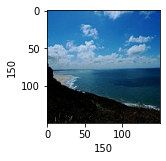

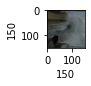

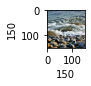

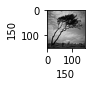

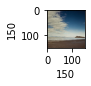

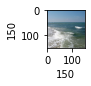

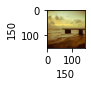

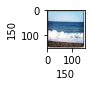

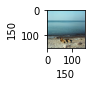

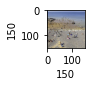

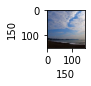

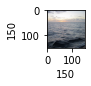

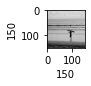

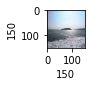

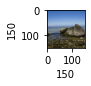

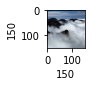

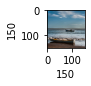

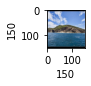

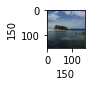

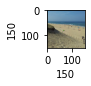

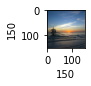

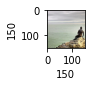

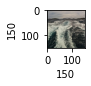

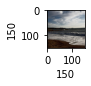

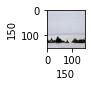

In [4]:
# 画像を表示して確認
plt.figure(figsize=(12,12))
path = './intel_images/seg_train/sea'
for i in range(1,26):
  plt.subplot(5,5,i)
  img = imread(path + '/' + random.choice(sorted(os.listdir(path))))
  plt.imshow(img)
  plt.xlabel(img.shape[1], fontsize=10)
  plt.ylabel(img.shape[0], fontsize=10)
  plt.show()

In [5]:
# ディレクトリから画像を取り出す、変換、リストに格納
image_list,label_list = [],[]
for directory in root_dir:
  for files in tqdm(os.listdir(f"{dir}/{directory}")):
    image_path = f"{dir}/{directory}/{files}"
    image = Image.open(image_path)
    image = image.resize((150,150))
    image = img_to_array(image)
    image_list.append(image)
    label_list.append(directory)

100%|██████████| 2191/2191 [22:13<00:00,  1.64it/s]


In [6]:
# ラベルを入れた変数の確認
label_count = pd.DataFrame(label_list).value_counts()
label_count

mountain     2512
glacier      2404
street       2382
sea          2274
forest       2271
buildings    2191
dtype: int64

In [7]:
# ラベルの数を確認
num_classes = len(label_count)
num_classes

6

In [8]:
#　訓練データの数とサイズを確認
np.array(image_list).shape

(14034, 150, 150, 3)

In [9]:
label_list = np.array(label_list)
label_list.shape

(14034,)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(image_list,label_list,test_size=0.2,random_state=123)

In [11]:
# 訓練データを型を変更しながらリシェイプ
X_train = np.array(X_train,dtype=np.float16) / 255.0
X_train = X_train.reshape(-1,150,150,3)
X_test = np.array(X_test,dtype=np.float16) / 255.0
X_test = X_test.reshape(-1,150,150,3)

In [12]:
# ラベルをワンホットエンコーディオング
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


データセットは数が多いので、次も使いやすいように処理済みの画像をnpy形式で保存しておきます。

In [13]:
xy = (X_train, X_test, y_train, y_test)
np.save('./processed_images.npy',xy)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [14]:
# ロードして保存ができているかを確認
X_train, X_test, y_train, y_test = np.load('processed_images.npy',allow_pickle=True)

## モデル構築

最初に扱うモデルはチュートリアル的なモデル。<br>
この結果を見てモデルを改善していきたいと思う。

In [15]:
model = Sequential()

model.add(Conv2D(32,3,input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(Conv2D(32,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))
adam = Adam(lr=1e-4)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.1)

Epoch 1/20
79/79 [==============================] - 30s 109ms/step - loss: 1.1940 - accuracy: 0.5288 - val_loss: 0.9487 - val_accuracy: 0.6411
Epoch 2/20
79/79 [==============================] - 7s 86ms/step - loss: 0.8825 - accuracy: 0.6783 - val_loss: 0.8136 - val_accuracy: 0.7097
Epoch 3/20
79/79 [==============================] - 7s 86ms/step - loss: 0.7476 - accuracy: 0.7305 - val_loss: 0.7017 - val_accuracy: 0.7516
Epoch 4/20
79/79 [==============================] - 7s 87ms/step - loss: 0.6551 - accuracy: 0.7647 - val_loss: 0.6525 - val_accuracy: 0.7578
Epoch 5/20
79/79 [==============================] - 7s 86ms/step - loss: 0.5815 - accuracy: 0.7947 - val_loss: 0.6021 - val_accuracy: 0.7943
Epoch 6/20
79/79 [==============================] - 7s 86ms/step - loss: 0.5286 - accuracy: 0.8192 - val_loss: 0.6292 - val_accuracy: 0.7783
Epoch 7/20
79/79 [==============================] - 7s 86ms/step - loss: 0.4854 - accuracy: 0.8318 - val_loss: 0.5894 - val_accuracy: 0.7854
Epoch 8/20


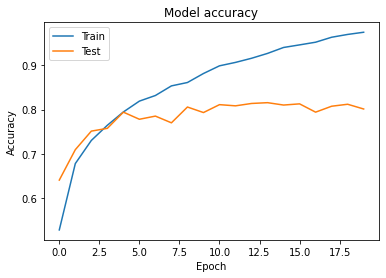

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

検証用データのACCだけを見ると、それなりにいい結果を出している。<br>
多分類で80を超え手はいるが、訓練用と比べると過学習気味になっているのも否めない。<br>
そこで、転移学習などは行わずにこのモデルに手を加える形で精度の向上を図っていきたい。

## モデルの調整

### ドロップアウトを追加

手っ取り早く過学習を抑えるには、ドロップアウト層を追加してみるという手がある。<br>
適度にプーリング層の後に追加して精度を比べてみる。

In [18]:
model = Sequential()

model.add(Conv2D(32,3,input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(Conv2D(32,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))
adam = Adam(lr=1e-4)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.1)

Epoch 1/20
79/79 [==============================] - 8s 97ms/step - loss: 1.3544 - accuracy: 0.4809 - val_loss: 1.0715 - val_accuracy: 0.6287
Epoch 2/20
79/79 [==============================] - 7s 89ms/step - loss: 1.0297 - accuracy: 0.6052 - val_loss: 0.9764 - val_accuracy: 0.6527
Epoch 3/20
79/79 [==============================] - 7s 89ms/step - loss: 0.9023 - accuracy: 0.6699 - val_loss: 0.8372 - val_accuracy: 0.7186
Epoch 4/20
79/79 [==============================] - 7s 89ms/step - loss: 0.8140 - accuracy: 0.7016 - val_loss: 0.7957 - val_accuracy: 0.7293
Epoch 5/20
79/79 [==============================] - 7s 90ms/step - loss: 0.7398 - accuracy: 0.7327 - val_loss: 0.7482 - val_accuracy: 0.7542
Epoch 6/20
79/79 [==============================] - 7s 90ms/step - loss: 0.6844 - accuracy: 0.7551 - val_loss: 0.6937 - val_accuracy: 0.7694
Epoch 7/20
79/79 [==============================] - 7s 90ms/step - loss: 0.6353 - accuracy: 0.7776 - val_loss: 0.6848 - val_accuracy: 0.7605
Epoch 8/20
79

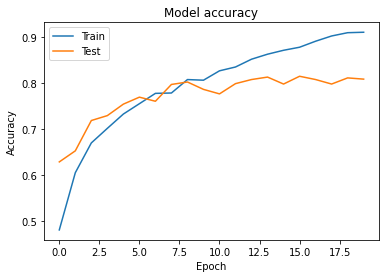

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

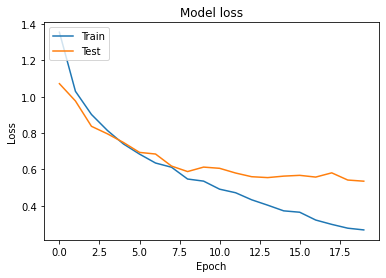

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

非常に簡単ではありますが、ドロップアウトを適度に追加するだけで汎化性能は明らかに上がりました。<br>
この調子ではもう少し性能が上がりそうなので、学習回数を少し増やしてみます。

### エポック数を増やす

In [22]:
model = Sequential()

model.add(Conv2D(32,3,input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(Conv2D(32,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))
adam = Adam(lr=1e-4)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, validation_split=0.1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
79/79 [==============================] - 8s 97ms/step - loss: 1.3323 - accuracy: 0.4692 - val_loss: 1.0868 - val_accuracy: 0.6180
Epoch 2/30
79/79 [==============================] - 7s 90ms/step - loss: 0.9996 - accuracy: 0.6205 - val_loss: 0.9435 - val_accuracy: 0.6554
Epoch 3/30
79/79 [==============================] - 7s 90ms/step - loss: 0.8845 - accuracy: 0.6691 - val_loss: 0.8732 - val_accuracy: 0.7008
Epoch 4/30
79/79 [==============================] - 7s 90ms/step - loss: 0.7863 - accuracy: 0.7050 - val_loss: 0.7831 - val_accuracy: 0.7373
Epoch 5/30
79/79 [==============================] - 7s 90ms/step - loss: 0.7226 - accuracy: 0.7382 - val_loss: 0.7816 - val_accuracy: 0.7293
Epoch 6/30
79/79 [==============================] - 7s 89ms/step - loss: 0.6678 - accuracy: 0.7587 - val_loss: 0.7394 - val_accuracy: 0.7409
Epoch 7/30
79/79 [==============================] - 7s 90ms/step - loss: 0.6299 - accuracy: 0.7744 - val_loss: 0.6709 - val_accuracy: 0.7747
Epoch 8/30
79

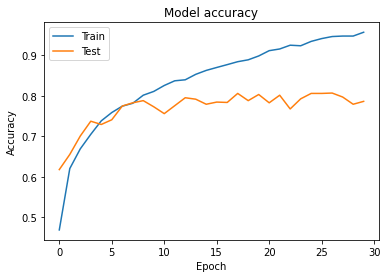

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

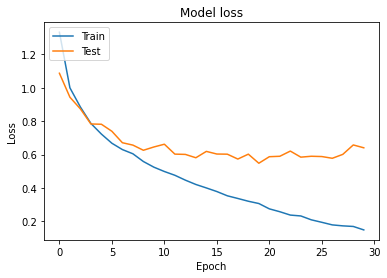

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

学習回数を上げてもこれ以上の精度の改善はできませんでした。<br>
学習が20回を超えたあたりで収束していることがわかります。<br>


メモリの都合上、ここまでしか無理なので、別のノートで検証を続けていきます。

**まとめ**
- ドロップアウト追加で効果あり
- エポック数はこれ以上増やしても意味なし